In [1]:
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import networkx as nx
import time
import os

# functions

In [2]:
def define_weights(G, q, hom):
    nx.set_edge_attributes(G, 0, 'q_kj')
    for node in G.nodes:
        if hom == 'in':
            K = [i for i,j in G.edges if j==node]
            partition = np.ones(len(K))/len(K)
            for i, k in enumerate(K):
                nx.set_edge_attributes(G, {(k,node): {'q_kj': q*partition[i]}})
        if hom == 'out':
            K = [j for i,j in G.edges if i==node]
            partition = np.ones(len(K))/len(K)
            for i, k in enumerate(K):
                nx.set_edge_attributes(G, {(node, k): {'q_kj': q*partition[i]}})

In [3]:
def create_graph(M, D, which, q, hom):
    '''input:
        M - length of a rib for D-grid
        D - dimention of the grid
        which can be 'CART' or 'ER'
            if 'CART' - two sided D-grid graph will be created
            if 'ER' - equivalent in number of nodes and edges random graph will be created
        q - coeficient of imitation
        hom - can be only 'in' or 'out', indicates homogeneity of nodes in q
       output:
        Specified graph with edge atributes 'q_kj' assigned accordingly to hom and q parameters
    '''
    if which=='CART':
        G = nx.DiGraph()
        CART_  = nx.grid_graph([M]*D, periodic=True)
        G.add_edges_from(CART_.edges)
        G.add_edges_from([(j,i) for i,j in CART_.edges])
    if which=='ER':
        num_edges = 2*D*(M**D)
        G = nx.gnm_random_graph(M**D, num_edges, directed=True)
    define_weights(G, q, hom)
    return G

In [4]:
def p_node_step(G, node, G_new, p):
    '''input:
        G - graph on which the diffusion is performed
        node - node
        G_new - graph where new adopters on this step are collected
            only when all nodes are updated, the graphs is updated
        p - inovation parameter
       output: None (function may change adopter attribute of the specified node in graph G_new)
    '''
    prob = p
    for ngbr in [i for i,j in G.edges if j==node]:
        if nx.get_node_attributes(G,'adopter')[ngbr]:
            prob+=nx.get_edge_attributes(G,'q_kj')[(ngbr, node)]
    if random.uniform(0,1)<prob:
        nx.set_node_attributes(G_new, {node:True}, 'adopter')

In [5]:
def p_graph_step(G, p):
    '''input:
        G - graph on which the diffusion is performed
        p - inovation parameter
       output: 
       G_new - graph G with new adopters
    '''
    G_new = G.copy()
    for node in G.nodes:
        if ~nx.get_node_attributes(G,'adopter')[node]:
            p_node_step(G, node, G_new, p)
    return G_new

In [6]:
def simulate_and_get_frac(M, D, which, q, hom, n_sim):
    '''input:
        G - graph to perform simulation on
        n_sim - number of simulations
       output:
        frac_np_all - nparray of shape (max_num_steps) of adopters for each step
    '''
    
    n_sim_np = np.empty((0, 1000))
     
    for i in range(n_sim):
        G = create_graph(M, D, which, q, hom) 
        M_all = G.number_of_nodes()
        nx.set_node_attributes(G, {i:False for i in G.nodes}, 'adopter')
        num_adopters = 0 
        frac_list = []  
        while num_adopters < M_all:
            #perform diffusion steps untill all nodes are adopters
            G = p_graph_step(G, p)
            vals = np.fromiter(nx.get_node_attributes(G,'adopter').values(), dtype=float)
            num_adopters = vals.sum()
            frac_list.append(num_adopters/M_all)
        frac_np = np.concatenate((np.array(frac_list), np.ones(1000-len(frac_list))))
        n_sim_np = np.concatenate((n_sim_np,frac_np.reshape(1,-1)))

    return n_sim_np.mean(0)

In [7]:
def simulate_and_get_influence(M, D, which, q, hom, n_sim):
    '''input:
        G - graph to perform simulation on
        n_sim - number of simulations
       output:
        frac_np_all - nparray of shape (max_num_steps) of adopters for each step
    '''

    dict_ME = {i: list() for i in range(M**D+1)}
    dict_ME[0].append(0)
    for i in range(n_sim):
        G = create_graph(M, D, which, q, hom) #simulates different graph every time for random graph
        M_all = G.number_of_nodes()
        # add node attribute 'adopter', at the begining of the diffusion it is 0 for all nodes
        nx.set_node_attributes(G, {i:False for i in G.nodes}, 'adopter')
        num_adopters_before = 0   
        influence = 0
        while num_adopters_before < M_all:
            #perform diffusion steps untill all nodes are adopters
            G = p_graph_step(G, p)
            adopter_status = np.fromiter(nx.get_node_attributes(G,'adopter').values(), dtype=float)
            num_adopters = adopter_status.sum()
            adopters = [list(G)[i] for i in np.nonzero(adopter_status)[0]]
            
            if num_adopters-num_adopters_before!=0:
                influence = 0
                for adopter in adopters:
                    for pair in G.edges(adopter):
                        if pair[1] not in adopters:
                            #for each adopter's edge-out we sum up it's influence on non-adopters
                            influence += nx.get_edge_attributes(G,'q_kj')[pair]
                dict_ME[num_adopters].append(influence)                           
            num_adopters_before = num_adopters

    return dict_ME, np.array([np.array(dict_ME[i]).sum()/len(dict_ME[i]) for i in dict_ME.keys()])

In [8]:
def plot_simulation(frac_dict_cart, frac_dict_ER, D, hom, frac=True):
    
    plt.figure(figsize=(20,5))
    for i, r in enumerate(frac_dict_cart.keys()):
        plt.subplot(1, 3, i+1)
        A = frac_dict_cart[r]
        frac_cart = A[(A!=1)]
        
        A = frac_dict_ER[r]
        frac_ER = A[(A!=1)]
        
        # plt.plot(frac_cart[0], label=f'cartesian grid {D}D', c='cornflowerblue')
        # plt.plot(frac_ER[0], label=f'Erdős–Rényi {D}D', c='darkseagreen')     
        plt.plot(frac_cart, c='cornflowerblue', label=f'Cartesian grid {D}D')
        plt.plot(frac_ER, c='darkseagreen', label=f'Erdős–Rényi {D}D')
        
        if frac:
            plt.plot(frac_cart.shape[0]-1, 1, c='b', marker='o')
            plt.plot(frac_ER.shape[0]-1, 1, c='g', marker='o')
            plt.xlabel('steps', fontsize=12)
        else:
            plt.xlabel('number of adopters', fontsize=12)
        if D==1 and frac:
            plt.plot(f_two_sided(np.arange(1, frac_cart.shape[0]+1), p=p, qp_ratio=r), c='b', ls='dashed', label='expected fraction of adopters for 1D circle')
        plt.legend()
        plt.title('$q/p=$'+str(r), fontsize=15)   
    if frac:
        plt.suptitle(f'simulation of fraction of adopters, homogeneity {hom}', fontsize=20) 
        plt.tight_layout()
        plt.savefig(f'mm_project/simulations_plot/fraction_{D}D_{hom}')
    else:
        plt.suptitle(f'simulation of influence of adopters, homogeneity {hom}', fontsize=20)  
        plt.tight_layout()
        plt.savefig(f'mm_project/simulations_plot/influence_{D}D_{hom}')
    
    plt.show()

In [9]:
def f_two_sided(t_vector, p, qp_ratio):
    return 1-np.exp(-p*(1+qp_ratio)*t_vector+qp_ratio*(1-np.exp(-p*t_vector)))

# simulation of fraction of adopters
### for different D in [1,2,3] and homogeneity ['in', 'out'] we compute and save a dictionary with keys as qp_ratio in [0.1, 1, 10]

CART_1D_in already saved
diffusion on ER_1D_in is running
it took 107.0 mins



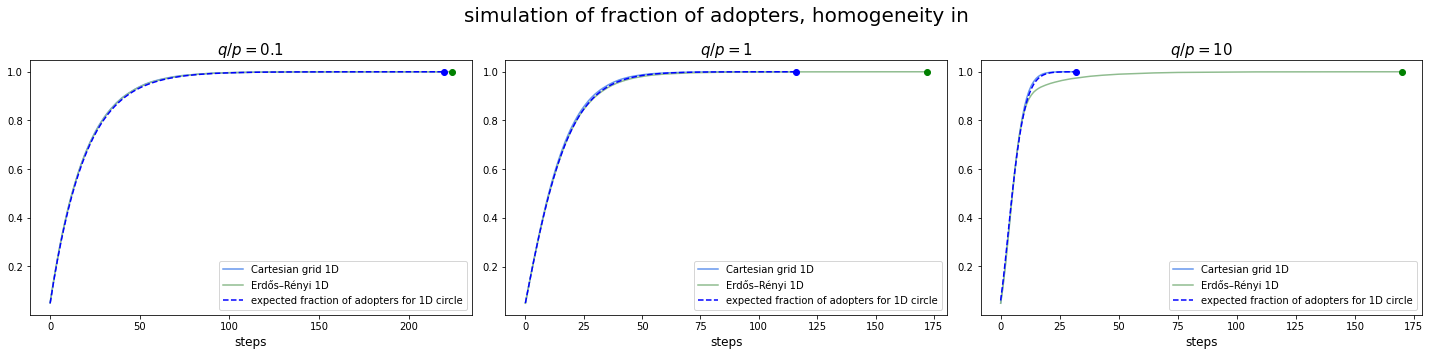

CART_1D_out already saved
diffusion on ER_1D_out is running
it took 110.0 mins



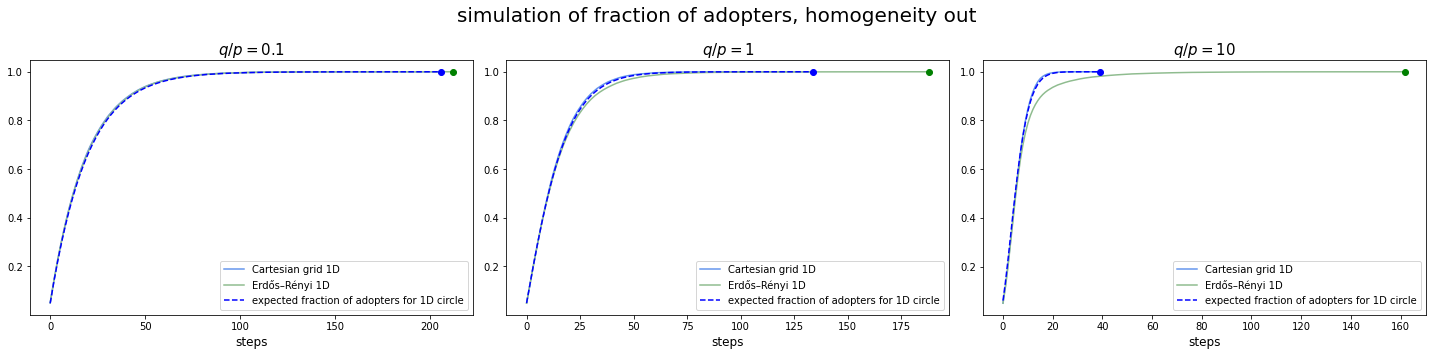

CART_2D_in already saved
diffusion on ER_2D_in is running
it took 214.0 mins



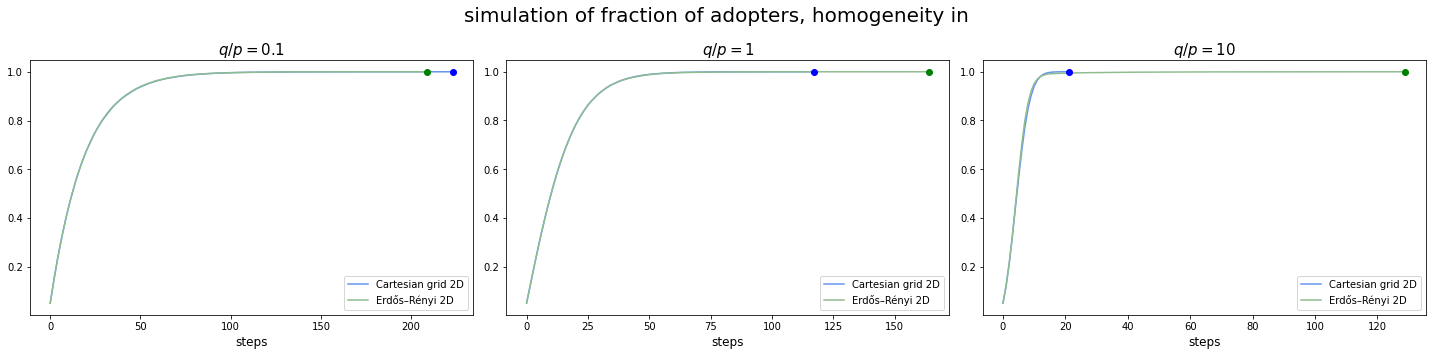

CART_2D_out already saved
diffusion on ER_2D_out is running
it took 236.0 mins



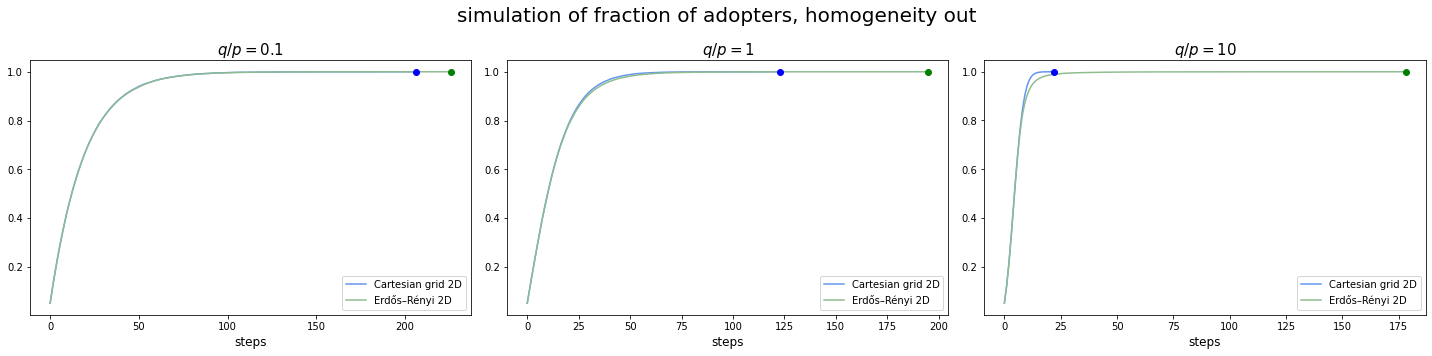

CART_3D_in already saved
diffusion on ER_3D_in is running
it took 140.0 mins



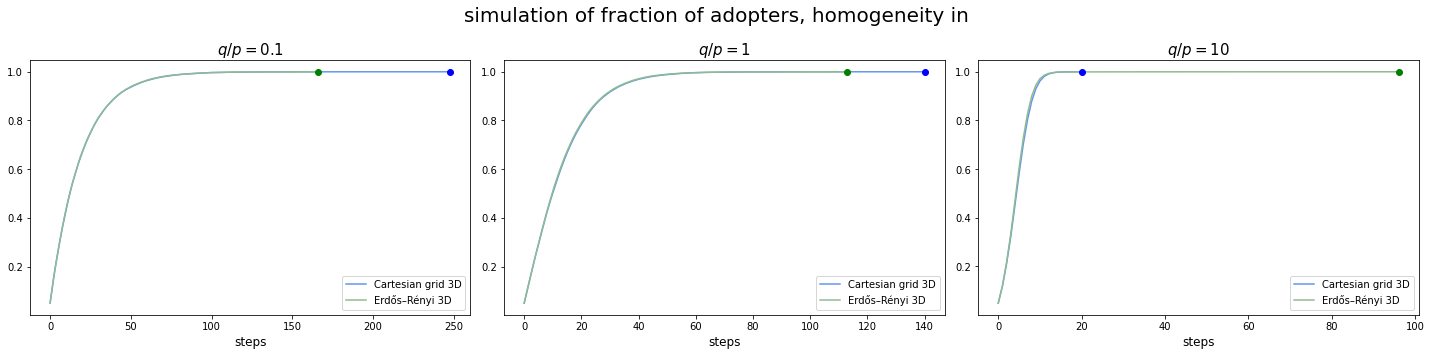

CART_3D_out already saved
diffusion on ER_3D_out is running
it took 150.0 mins



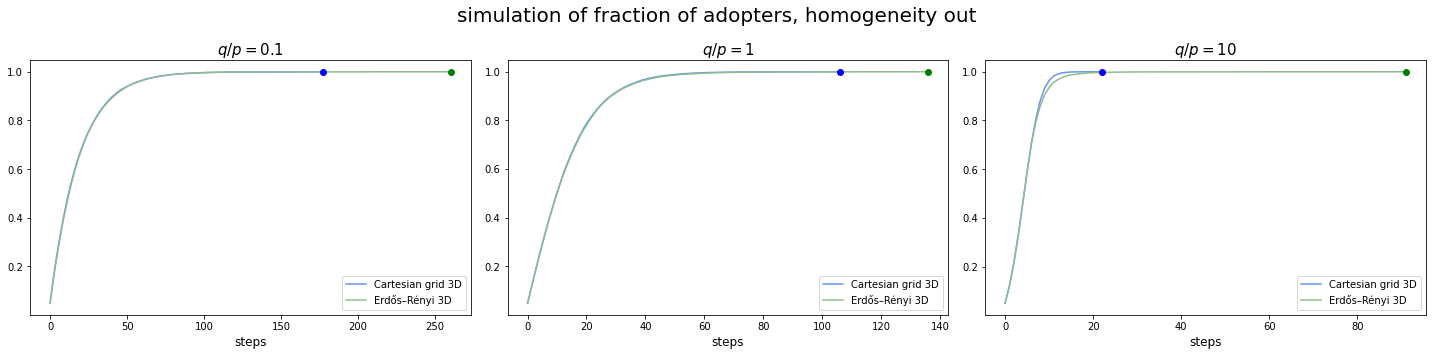

In [10]:
p = 0.05
m = 100
n_sim = 1000

if not (f'frac_M{m}_nsim{n_sim}' in os.listdir('mm_project/simulations')):
    os.mkdir(f'mm_project/simulations/frac_M{m}_nsim{n_sim}')
    
for D in [1, 2, 3]:
    M = int(m**(1/D))
    for hom in ['in', 'out']:
        for which in ['CART', 'ER']:
            if f'{which}_{D}D_{hom}' in os.listdir(f'mm_project/simulations/frac_M{m}_nsim{n_sim}'):
                print(f'{which}_{D}D_{hom} already saved')
            else:
                print(f'diffusion on {which}_{D}D_{hom} is running')
                start_time = time.time()
                frac_dict = {}
                for qp_ratio in [0.1, 1, 10]:
                    q = qp_ratio*p

                    frac_dict[qp_ratio] = simulate_and_get_frac(M, D, which, q, hom, n_sim)
                pickle.dump(frac_dict, open(f'mm_project/simulations/frac_M{m}_nsim{n_sim}/{which}_{D}D_{hom}', 'wb'))
                print(f'it took {(time.time()-start_time)//60} mins\n')
            globals()[f'frac_dict_{which}'] = pickle.load(open(f'mm_project/simulations/frac_M{m}_nsim{n_sim}/{which}_{D}D_{hom}', 'rb'))
        plot_simulation(frac_dict_CART, frac_dict_ER, D, hom, frac=True)

# simulation of influence

ME_CART_1D_out already saved
diffusion on ER_1D_out is running
it took 82.0 mins



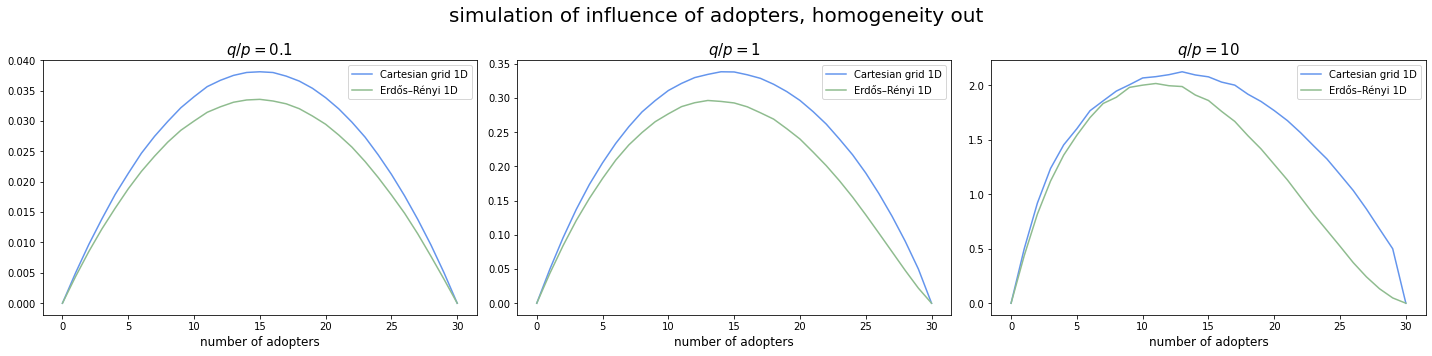

ME_CART_1D_in already saved
diffusion on ER_1D_in is running
it took 79.0 mins



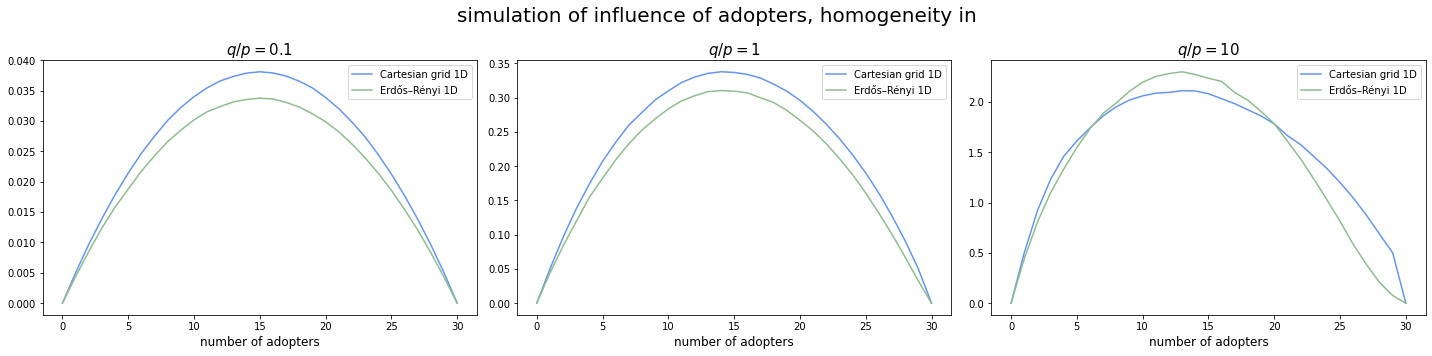

ME_CART_2D_out already saved
diffusion on ER_2D_out is running
it took 114.0 mins



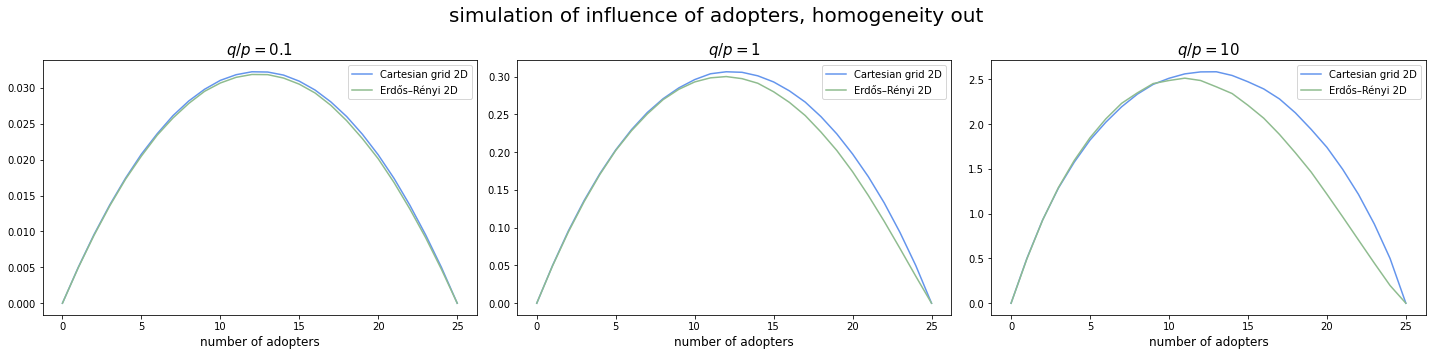

ME_CART_2D_in already saved
diffusion on ER_2D_in is running
it took 107.0 mins



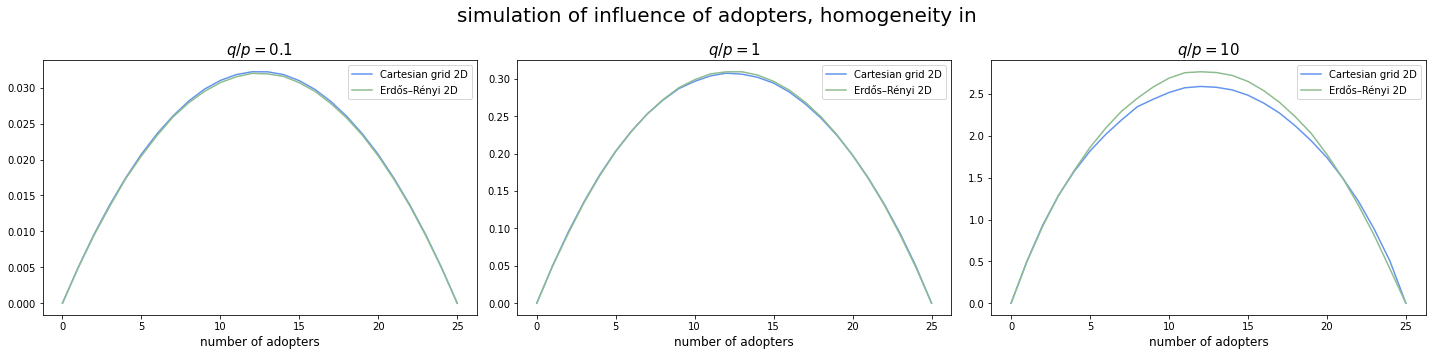

ME_CART_3D_out already saved
diffusion on ER_3D_out is running
it took 237.0 mins



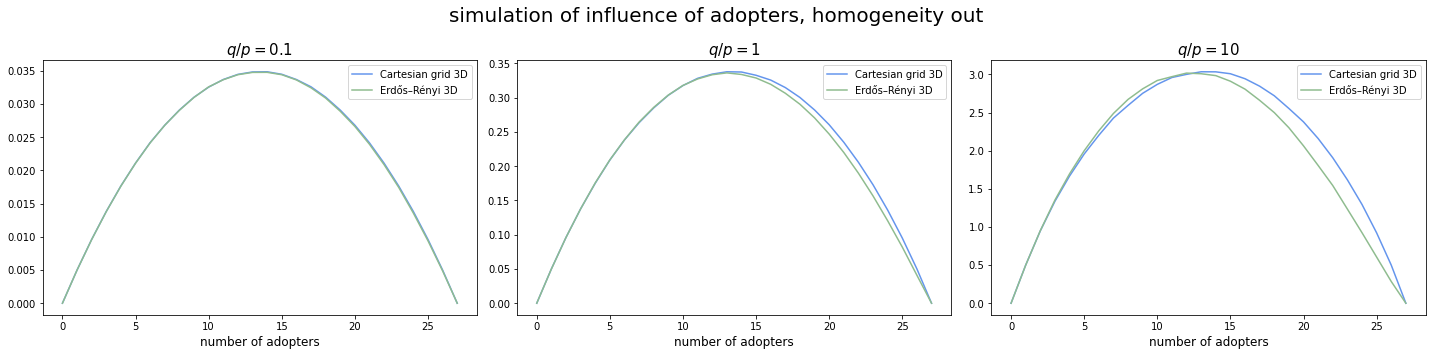

ME_CART_3D_in already saved
diffusion on ER_3D_in is running
it took 236.0 mins



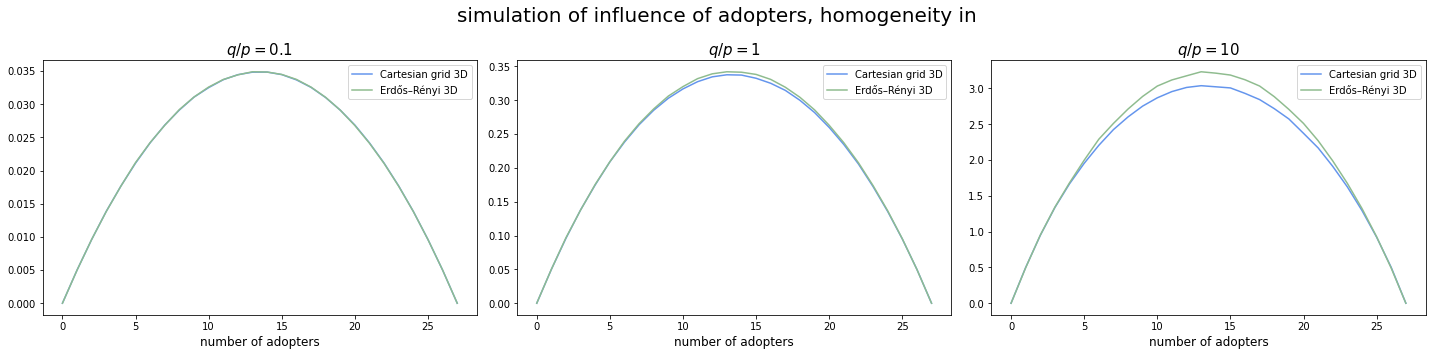

In [11]:
m = 30
n_sim = 10000
if not (f'ME_M{m}_nsim{n_sim}' in os.listdir('mm_project/simulations')):
    os.mkdir(f'mm_project/simulations/ME_M{m}_nsim{n_sim}')
    
for D in [1, 2, 3]:
    M = int(m**(1/D))
    for hom in ['out', 'in']:
        for which in ['CART', 'ER']:
            if f'ME_{which}_{D}D_{hom}' in os.listdir(f'mm_project/simulations/ME_M{m}_nsim{n_sim}'):
                print(f'ME_{which}_{D}D_{hom} already saved')
            else:
                print(f'diffusion on {which}_{D}D_{hom} is running')
                start_time = time.time()
                infl_dict = {}
                for qp_ratio in [0.1, 1, 10]:
                    q = qp_ratio*p
                    
                    a, infl_dict[qp_ratio] = simulate_and_get_influence(M, D, which, q, hom, n_sim)
                    pickle.dump(a, open(f'mm_project/simulations/ME_M{m}_nsim{n_sim}/ME_DICT_{which}_{D}D_{hom}_r{qp_ratio}', 'wb'))
                pickle.dump(infl_dict, open(f'mm_project/simulations/ME_M{m}_nsim{n_sim}/ME_{which}_{D}D_{hom}', 'wb'))
                print(f'it took {(time.time()-start_time)//60} mins\n')
            globals()[f'infl_dict_{which}'] = pickle.load(open(f'mm_project/simulations/ME_M{m}_nsim{n_sim}/ME_{which}_{D}D_{hom}', 'rb'))
        plot_simulation(infl_dict_CART, infl_dict_ER, D, hom, frac=False)